In [1]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
import random

# Functions

**Crop image**

In [2]:
def get_background_value(im):
    # Obtain image histogram and extract all pixel value ranges that appear
    # at least a fifth the number of times that the most common pixel value range appears.
    # From these, select the range that starts with the smallest value and return this respective value
    bins=np.arange(255)[::10]
    count,loc = np.histogram(im,bins=bins)
    smallest_background = np.where(count/count.max()>0.2)[0][0]
    loc_max = loc[smallest_background]
    return loc_max

In [3]:
def threshold(im,background_value):

    # Threshold image around background value.
    ret, thresh = cv2.threshold(im.copy().astype('uint8'), background_value, 255, cv2.THRESH_BINARY_INV)
    
    # Erosion and dilation to remove unwanted small background portions that were not removed by thresholding.
    kernel = np.ones((3,3),np.uint8)
    for i in range(10):
        thresh = cv2.erode(thresh, kernel, iterations=2)
        thresh = cv2.dilate(thresh, kernel, iterations=1)

    # Transform thresholded RGB image to 2D (grayscale) and threshold again to obtain a binary image. 
    thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(thresh.copy().astype('uint8'), 0, 255, 0)
    #thresh = cv2.dilate(thresh, kernel, iterations=20)
    return thresh

In [4]:
def contours(thresh):
    # Get contours of all spots that were not removed by thresholding.
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]

    # Get the bounding box corrdinates of all spots and only keep boxes with larger sizes.
    eligible_boxes = []
    for i in range(len(contours)):
        x,y,w,h = cv2.boundingRect(contours[i]) 
        if w>100 or h>100:
            eligible_boxes.append((x,y,w,h))

    # Out of the boxes with large sizes, some are in the image corners and just stem from
    # the image corners being shadier than the rest. 
    # The corner spots are not considered.
    # Get the areas of all bounding boxes.
    areas = []
    for i,box in enumerate(eligible_boxes):
        if (box[0]!=0 and box[1]!=0) and ((box[0]+box[2])!=im.shape[1]) and ((box[1]+box[3])!=im.shape[0]):
            areas.append((i,box[2]*box[3]))
    
    # After removing the corner spots, almost all spots are related to the pill.
    # Some spots are inside the pill and stem from unequal lighting in the original photo.
    # Choose the largest spot - it relates to the whole pill, not a small portion of it.
    areas = np.array(areas)
    idx_max_area = areas[np.argmax(areas[:,1]),0]
    final_box = eligible_boxes[idx_max_area]
    y = final_box[0]
    x = final_box[1]
    w = final_box[2]
    h = final_box[3]

    return x,y,w,h

In [5]:
def get_crop(im,x,y,w,h):
    diff_up,diff_down,diff_right,diff_left = 0,0,0,0

    # Between the height and width of the bounding box, the largest side is chosen 
    # and set as the size of the square crop.
    # For the box side which is initially smaller, the extra length is taken from both (up,down) or (left,right) sides. 
    # An additional 200-pixel length is taken on all sides of the bounding box, to assure that the pill is captured within.
    # Resize crop to (224,224)
    if w>h:
        mid = int((w-h)/2)
        if y+w+200 > im.shape[1]:
            diff_right = y+w+200-im.shape[1]
        if y-200 < 0:
            diff_left = 200-y
        if x-mid-200 < 0:
            diff_up = 200+mid-x
        if x+h+mid+200 > im.shape[0]:
            diff_down = x+h+mid+200 - im.shape[0]
        crop = im[np.max([x-mid-200-diff_down,0]) : x+h+mid+200+diff_up, np.max([y-200-diff_right,0]) : y+w+200+diff_left]
        #print(x-mid-200-diff_down,x+h+mid+200+diff_up,y-200-diff_right,y+w+200+diff_left)
   
    else:
        mid = int((h-w)/2)
        if y+w+mid+200 > im.shape[1]:
            diff_right = y+w+mid+200-im.shape[1]
        if y-mid-200 < 0:
            diff_left = 200+mid-y
        if x-200 < 0:
            diff_up = 200-x
        if x+h+200 > im.shape[0]:
            diff_down = x+h+200 - im.shape[0]
        crop = im[np.max([x-200-diff_down,0]) : x+h+200+diff_up, np.max([y-mid-200-diff_right,0]) : y+w+mid+200+diff_left]
        #print(x-200-diff_down,x+h+200+diff_up,y-mid-200-diff_right,y+w+mid+200+diff_left,)

    crop = cv2.resize(crop,(224,224))
    return crop[:,:,::-1]

**Repeat for all images**

In [6]:
def preprocess(raw_dir_name,preprocessed_dir_name):
    for full_category_name in os.listdir(raw_dir_name)[:-1]: 
        category_number = str.split(full_category_name)[1].split('_')[0]
        short_category_name = str.split(full_category_name)[1].split('_')[1]
        os.makedirs("{}\\{}".format(preprocessed_dir_name,short_category_name))

        files = os.listdir("{}\\{}\\".format(raw_dir_name,full_category_name))
        for order,image_ID in enumerate(files):
            # Create unique ID for each pill: {pill_category_number}_{idx_within_category}
            pill_uniqueID = "{}_{}".format(category_number,order+1)

            # Load image, crop left part of image and transform cv2 image from BGR to RGB.
            im = cv2.imread("{}\\{}\\{}".format(raw_dir_name,full_category_name,image_ID))
            im = im[:,700:,::-1]

            background_value = get_background_value(im)
            thresholded_im = threshold(im,background_value)
            x,y,w,h = contours(thresholded_im)
            crop = get_crop(im,x,y,w,h)

            save_path = "{}\\{}\\{}.jpg".format(preprocessed_dir_name,short_category_name,pill_uniqueID)
            cv2.imwrite(save_path,crop)

**Sort into train & test sets**

In [7]:
def train_test(train_test,no_of_classes,test_size):
    x_train_ordered,x_test_ordered = [],[]
    y_train_ordered,y_test_ordered = [],[]
    
    if no_of_classes==19:
        categories = os.listdir(preprocessed_dir_name)[::-1]
    elif no_of_classes==20:
        categories = os.listdir(preprocessed_dir_name)

    for category_name in categories: 
        # from each pill category, place first 16 images in train set and following 4 images in test set
        files = os.listdir("{}\\{}\\".format(preprocessed_dir_name,category_name))
        for idx,file in enumerate(files):

            im = cv2.imread("{}\\{}\\{}".format(preprocessed_dir_name,category_name,file))
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            if test_size==4:
                if idx<16:
                    x_train_ordered.append(im)
                elif idx>=16 and idx<20:
                    x_test_ordered.append(im)
            elif test_size==3:
                if idx<17:
                    x_train_ordered.append(im)
                elif idx>=17 and idx<20:
                    x_test_ordered.append(im)
        # place first 17/16 image labels in train set and following 3/4 labels in test set
        if test_size==4:
            y_train_ordered = y_train_ordered + [int(file.split('_')[0])] * 16
            y_test_ordered = y_test_ordered + [int(file.split('_')[0])] * 4
        elif test_size==3:
            y_train_ordered = y_train_ordered + [int(file.split('_')[0])] * 17
            y_test_ordered = y_test_ordered + [int(file.split('_')[0])] * 3

    x_train_ordered = np.array(x_train_ordered)
    x_test_ordered = np.array(x_test_ordered)
    y_train_ordered = np.array(y_train_ordered)
    y_test_ordered = np.array(y_test_ordered)
    
    # shuffle x_train & x_test, which currently contain ordered pill caegories
    idx_train = random.sample(range(len(x_train_ordered)),len(x_train_ordered))
    idx_test = random.sample(range(len(x_test_ordered)),len(x_test_ordered))

    x_train = x_train_ordered[idx_train]
    y_train = y_train_ordered[idx_train]

    x_test = x_test_ordered[idx_test]
    y_test = y_test_ordered[idx_test]
    
    # save dataset
    np.save("{}_{}classes_testsize{}\\x_train.npy".format(train_test,no_of_classes,test_size),x_train)
    np.save("{}_{}classes_testsize{}\\x_test.npy".format(train_test,no_of_classes,test_size),x_test)
    np.save("{}_{}classes_testsize{}\\y_train.npy".format(train_test,no_of_classes,test_size),y_train)
    np.save("{}_{}classes_testsize{}\\y_test.npy".format(train_test,no_of_classes,test_size),y_test)

# Function calls

In [8]:
train_test = '.\\Data\\train_test'
raw_dir_name = '.\\Data\\Raw\\'
preprocessed_dir_name = '.\\Data\\Preprocessed\\'

preprocess(raw_dir_name,preprocessed_dir_name)
train_test(train_test,19,3)
train_test(train_test,19,4)
train_test(train_test,20,3)
train_test(train_test,20,4)

# Step-wise detailed example: preprocessing

load image

In [9]:
pill_name = 'Pill 11_CIPRINOL_500mg_KRKA'
ID = 'DSC_8309'
file_name = '.\\Data\\Raw\\{}\\{}.jpg'.format(pill_name,ID)
im = cv2.imread(file_name)[:,700:,::-1]

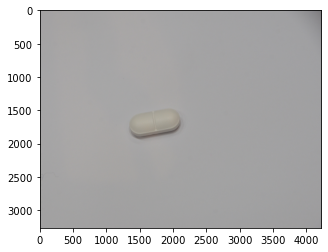

In [10]:
plt.imshow(im)

background

In [11]:
bins=np.arange(255)[::10]
count,loc = np.histogram(im,bins=bins)

In [12]:
smallest_background = np.where(count/count.max()>0.2)[0][0]
loc_max = loc[smallest_background]
loc_max

160

<BarContainer object of 25 artists>

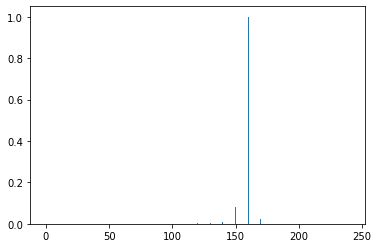

In [13]:
plt.bar(loc[:-1],count/count.max())

threshold

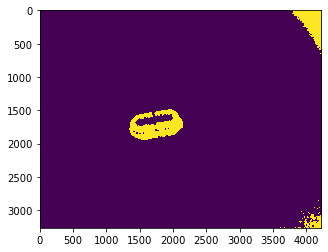

In [14]:
ret, thresh = cv2.threshold(im.copy().astype('uint8'), loc_max, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((3,3),np.uint8)
for i in range(10):
    thresh = cv2.erode(thresh, kernel, iterations=2)
    thresh = cv2.dilate(thresh, kernel, iterations=1)

thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(thresh.copy().astype('uint8'), 0, 255, 0)
#thresh = cv2.dilate(thresh, kernel, iterations=20)

plt.imshow(thresh,interpolation='none')

contours

In [15]:
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]

eligible_boxes = []
for i in range(len(contours)):
    x,y,w,h = cv2.boundingRect(contours[i]) 
    print(x,y,w,h)
    if w>100 or h>100:
        eligible_boxes.append((x,y,w,h))

3927 3261 3 3
3543 3261 5 3
3678 3260 8 4
3585 3253 25 11
3874 3249 32 15
3962 3247 8 17
3862 3247 3 3
3782 3245 8 7
3750 3243 10 21
3811 3242 42 22
3655 3236 41 28
3593 3235 4 6
3939 3231 12 6
3757 3209 9 13
3881 3155 40 32
3927 3106 12 16
3953 3088 21 22
3972 3083 5 3
3986 3076 6 4
4005 3058 21 66
4208 3055 20 6
3954 3042 274 222
4084 3221 24 23
3984 3209 23 23
4028 3042 14 5
3950 3038 7 10
3935 3035 10 5
4058 3026 10 3
4016 3018 16 19
4125 3017 12 5
3966 3015 6 21
3919 3015 3 4
4155 3006 5 6
4102 3003 18 9
4084 2978 9 4
4110 2947 26 12
4154 2939 74 108
4159 2935 3 3
4055 2930 21 13
4038 2922 4 4
4151 2874 3 5
4175 2848 3 11
4219 2474 9 3
2100 1802 10 10
1340 1483 808 466
1476 1834 46 25
1536 1829 23 23
1441 1828 24 24
1396 1810 33 24
1721 1777 61 41
1873 1769 23 23
1914 1760 23 23
4201 608 27 53
4099 478 3 6
4016 348 8 7
3910 189 22 13
3879 171 3 3
3735 23 3 4
3754 0 474 620
3869 106 22 17


In [16]:
areas = []
for i,box in enumerate(eligible_boxes):
    if (box[0]!=0 and box[1]!=0) and ((box[0]+box[2])!=im.shape[1]) and ((box[1]+box[3])!=im.shape[0]):
        areas.append((i,box[2]*box[3]))

areas = np.array(areas)
idx_max_area = areas[np.argmax(areas[:,1]),0]
final_box = eligible_boxes[idx_max_area]
y = final_box[0]
x = final_box[1]
w = final_box[2]
h = final_box[3]

diff_up,diff_down,diff_right,diff_left = 0,0,0,0

if w>h:
    mid = int((w-h)/2)
    
    if y+w+200 > im.shape[1]:
        diff_right = y+w+200-im.shape[1]
    if y-200 < 0:
        diff_left = 200-y
    if x-mid-200 < 0:
        diff_up = 200+mid-x
    if x+h+mid+200 > im.shape[0]:
        diff_down = x+h+mid+200 - im.shape[0]
    
    crop = im[np.max([x-mid-200-diff_down,0]) : x+h+mid+200+diff_up, np.max([y-200-diff_right,0]) : y+w+200+diff_left]
    print(x-mid-200-diff_down,x+h+mid+200+diff_up,y-200-diff_right,y+w+200+diff_left)
else:
    mid = int((h-w)/2)
    
    if y+w+mid+200 > im.shape[1]:
        diff_right = y+w+mid+200-im.shape[1]
    if y-mid-200 < 0:
        diff_left = 200+mid-y
    if x-200 < 0:
        diff_up = 200-x
    if x+h+200 > im.shape[0]:
        diff_down = x+h+200 - im.shape[0]
    print(x-200-diff_down,x+h+200+diff_up,y-mid-200-diff_right,y+w+mid+200+diff_left,)
    crop = im[np.max([x-200-diff_down,0]) : x+h+200+diff_up, np.max([y-mid-200-diff_right,0]) : y+w+mid+200+diff_left]


1112 2320 1140 2348


(1208, 1208, 3)

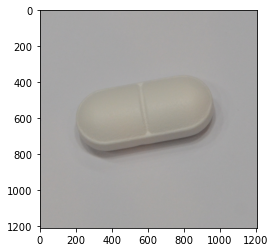

In [17]:
plt.imshow(crop)
crop.shape

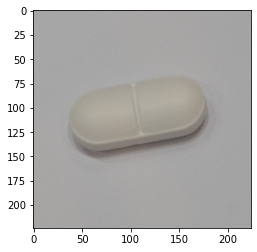

In [18]:
plt.imshow(cv2.resize(crop,(224,224)))